# Mobilenetv2 for Testing
We are going to use a mobilnet to train a model and see how it does

____

## Loading Packages

In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 #for our model
from tensorflow.keras.utils import Sequence, to_categorical # For our own data generator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

import cv2 # For image processing


## Building Generator

In [56]:
#https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self,
                 csv_file, # file that has the images on it, as well as the image types
                 y_var = 'grapheme_root', #'grapheme_root','vowel_diacritic','consonant_diacritic' 
                 to_fit=True,
                 batch_size=32,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True):
        """Initialization
        :param csv_File #CSV file that has the path to the stores on it
        :param y_var: a list of 'root','voewl','consonant'
        :param to_fit: Provive the dependent variable as well
        :param batch_size: The size of each batch to deliver
        :param dim: dimensions of the photos to use
        :param channels: The number of channals of the photo - 1 is bw, 3 is color, any other is customer
        :param vertical_flip: (dbl) The percent chance to flip a photo along a vertical axis
        :param horizontal_flip: (dbl) The percent chance to flip a photo along a horiszontal axis
        :param rotate: (tuple - (prob, degree)) A two unit tuple, first is the % chance of rotate, the next is the amount of rotation
        :param shear: (tuple - (prob, amt)) A two unit tuple, first is the % chance of shear, the next is the amount of shear
        :param shuffle: True to shuffle label indexes after every epoch
        """
        
        #Getting Index that we will use to sort
        
        self.Idx_List = np.arange(csv_file.shape[0])
        
        # Loading y_Vars
        if isinstance(y_var, list):
            y_var = y_var[0]
            
        self.y_var = csv_file[y_var].values
       
        #TODO Move this to the aabove if statement, removing the need for y_var, and y
        self.y_dim = 0
        self.hot_encode_y()
        #self.y = self.y_var
        # getting Images Location
        self.Imgs = csv_file.Image_Dir.values
        
        #Setting other vars
        self.batch_size = batch_size
        self.fit = to_fit
        self.shuffle = shuffle
        
        self.dim = dim
        self.channels = channels
        if self.channels == 1:
            self.read_mode = cv2.IMREAD_GRAYSCALE
        elif self.channels == 3:
            self.read_mode = cv2.IMREAD_COLOR
        else:
            self.read_mode = cv2.IMREAD_UNCHANGED
        
        assert 0 <= vertical_flip <=1, "vertical_flip = {}, which is not between 0 or 1".format(vertical_flip)
        self.v_flip = vertical_flip
        
        assert 0 <= horizontal_flip <=1, "horizontal_flip = {}, which is not between 0 or 1".format(horizontal_flip)
        self.h_flip = horizontal_flip
        
        assert 0 <= rotate[0] <=1, "first value of rotate = {}, which is not between 0 or 1".format(rotate[0])
        self.r_prob = rotate[0]
        assert 0 <= rotate[1] < 360, "second value of rotate = {}, which is not between 0 or 359".format(rotate[1])
        self.r_deg = rotate[1]
        
        assert 0 <= shear[0] <=1, "first value of shear = {}, which is not between 0 or 1".format(shear[0])
        self.s_prob = shear[0]
        
        assert 0 <= shear[1] <=359, "first value of shear = {}, which is not between 0 or 359".format(shear[1])
        self.s_fact = shear[1]
        #self.on_epoch_end()
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.Idx_List) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        Batch_Idx = self.Idx_List[index * self.batch_size:(index + 1) * self.batch_size]


        # Generate data
        X = self._generate_X(Batch_Idx)

        if self.fit:
            y = self._generate_y(Batch_Idx)
            return X, y
        else:
            return X
        
    #TODO at a def __iter__ and __next__ methodology so we can loop through it!

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        #self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.Idx_List)

    def _generate_X(self, Batch_Idx):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.channels))

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            X[i,] = self._load_image(self.Imgs[ID])

        return X

    def _generate_y_bck(self, Batch_Idx):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(Batch_Idx):
            # Store sample
            y[i,] = self._load_image(self.mask_path + self.labels[ID])

        return y
    
    def _generate_y(self, Batch_Idx):
        y = self.y[Batch_Idx,:]
        #y = self.y[Batch_Idx]
        return y
    
    def hot_encode_y(self):
        #self.y = pd.get_dummies(pd.Categorical(self.y_var)).values
        self.y = to_categorical(self.y_var)
        print("Number of Encodings is {}".format(self.y.shape[1]))
        self.y_dim = self.y.shape[1]
        


    def _load_image(self, image_path):
        
        img = cv2.imread(image_path,  self.read_mode) #load an image as grayscale
        
        if img.shape != self.dim:
            img = cv2.resize(img, self.dim)
        
        img = self._flip_vertical(img)
        
        img = self._flip_horizontal(img)
        
        img = self._rotate(img)
        
        img = self._shear(img)
        
        img = img/255.0
        if self.channels == 1:
            #img = img.reshape(self.dim[0],self.dim[1],self.channels)
            img = np.expand_dims(img,2)

        return(img)
        
    def _flip_vertical(self, img):
        """Flips and image on a  vertica axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.v_flip < np.random.uniform():
            img = cv2.flip(img,1)
            return(img)
        else:
            return(img)
        
    def _flip_horizontal(self, img):
        """Flips and image on a horizontal axis, as set by v_flip,
        if set to zero, will never flip the image """
        if 1 - self.h_flip < np.random.uniform():
            img = cv2.flip(img,0)
            return(img)
        else:
            return(img)
        
    def _rotate(self, img):
        if 1 - self.r_prob < np.random.uniform():
            rows, cols = img.shape[0], img.shape[1]
            #TODO allow a rotation both forward and backwards
            Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(self.r_deg), 1)
            img = cv2.warpAffine(img, Rot_M, (cols, rows))
            return(img)
        else:
            return(img)
        
    def _shear(self, img):
        """
        https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/
        """
        if 1 - self.s_prob < np.random.uniform():
            #TODO allow a shear both forward and backwards
            rows, cols = img.shape[0], img.shape[1]
            
            shear_factor = np.random.uniform(self.s_fact)
            
            M = np.array([[1, shear_factor, 0],[0,1,0]])
            nW =  RR.shape[1] + abs(shear_factor*img.shape[0])
            img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
            img = cv2.resize(img, (cols,rows))
            return(img)
        else:
            return(img)

In [161]:
Gen_Train2 = DataGenerator(
                csv_file = CSV_Train,
                 y_var = 'root',
                 to_fit=True,
                 batch_size=2,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (.50,90), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=False)


Number of Encodings is 168


(90, 160)

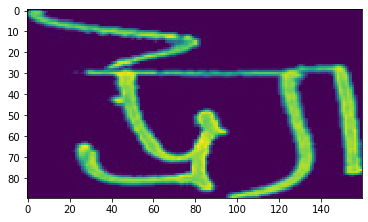

In [189]:
ZZ = Gen_Train2[1]
plt.imshow(ZZ[0][1].reshape((90,160)))
ZZ[0][1].shape
#ZZ_1 = ZZ[0].reshape(ZZ[0].shape[0],ZZ[0].shape[1], ZZ[0].shape[2],1)

## Reading in CSV Data and creating Generators

In [3]:
CSV = pd.read_csv('../Data/train_extra.csv')

#removing Test
CSV = CSV[CSV.Train == 0]

# spling into train and validate
Idx_Split = np.random.uniform(size = CSV.shape[0])
CSV_Val = CSV[Idx_Split <= 0.2]
CSV_Train = CSV[Idx_Split > 0.2]

print("Shape of Train is: {} x {} \nShape of Val is {} x {}".format(CSV_Train.shape[0], 
                                                                    CSV_Train.shape[1],
                                                                    CSV_Val.shape[0], 
                                                                    CSV_Val.shape[1]))


Shape of Train is: 136369 x 7 
Shape of Val is 34268 x 7


In [4]:
CSV.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,Train,Image_Dir
0,Train_0,15,9,5,ক্ট্রো,0,../Data/Train/Train_0.jpg
1,Train_1,159,0,0,হ,0,../Data/Train/Train_1.jpg
2,Train_2,22,3,5,খ্রী,0,../Data/Train/Train_2.jpg
4,Train_4,71,9,5,থ্রো,0,../Data/Train/Train_4.jpg
7,Train_7,139,3,0,ষী,0,../Data/Train/Train_7.jpg


In [165]:
Gen_Train = DataGenerator(
                csv_file = CSV_Train,
                 y_var = 'root',
                 to_fit=True,
                 batch_size=128,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (.50,90), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True)

Gen_Val = DataGenerator(
                csv_file = CSV_Val,
                 y_var = 'root',
                 to_fit=True,
                 batch_size=32,
                 dim = (90,160),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #Prob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True)


print("Shape of target is {} , number of batches per epoch is {} x {}".format(len(np.unique(Gen_Train.y)),
                                                                                 len(Gen_Train),
                                                                                 len(Gen_Val)))

Number of Encodings is 168
Number of Encodings is 168
Shape of target is 2 , number of batches per epoch is 1067 x 1064


## Loading Model

In [69]:
def build_MNV2(input_shape,
               alpha = 1,
               weights = None,
               dropout_per = 0.2,
               target_size = 168,
              learning_rate = 0.0002):
    mobilenetV2 = MobileNetV2(
        input_shape = input_shape,
        alpha = alpha,
        weights=weights,
        include_top=False
    )
    #Making all layers in MobilenetV2 trainable!
    for layer in mobilenetV2.layers:
        layer.trainable = True
        
    model = Sequential()
    model.add(mobilenetV2)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout_per))
    model.add(layers.Dense(target_size, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
  
    return model


def build_minst(input_shape,
                dropout_per,
               target_size,
               learning_rate = 0.0002):
    
    mnst_model = Sequential([
    # This is the first convolution
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),
    # The second convolution
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(128, activation='relu'),
    # drop out layer
    layers.Dropout(dropout_per),
    layers.Dense(target_size, activation='softmax')
    ])

    mnst_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=learning_rate),
        #optimizer = optimizers.RMSprop(learning_rate = learning_rate )    ,
        metrics=['accuracy']
        )
    return mnst_model
    

In [8]:
model = build_MNV2(input_shape = (90,160,1))
type(model)

tensorflow.python.keras.engine.sequential.Sequential

In [12]:
model = build_MNV2(input_shape = (90,160,1), adam_learning_rate = 0.002)
model = compile_model(model, 0.002)

history = model.fit_generator(
    Gen_Train,
    epochs=10,
    verbose=1,
    validation_data = Gen_Val,
)

Epoch 1/10


W0130 13:06:05.271191 140040918865728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1068/1068 [==============================] - 844s 790ms/step - loss: 4.7391 - accuracy: 0.0265 - val_loss: 5.8342 - val_accuracy: 0.0282
Epoch 2/10
1068/1068 [==============================] - 844s 791ms/step - loss: 4.7051 - accuracy: 0.0274 - val_loss: 5.2735 - val_accuracy: 0.0278
Epoch 3/10
1068/1068 [==============================] - 843s 789ms/step - loss: 4.7014 - accuracy: 0.0279 - val_loss: 4.8950 - val_accuracy: 0.0278
Epoch 4/10
1068/1068 [==============================] - 844s 790ms/step - loss: 4.7009 - accuracy: 0.0280 - val_loss: 4.7566 - val_accuracy: 0.0281
Epoch 5/10
1068/1068 [==============================] - 843s 790ms/step - loss: 4.6985 - accuracy: 0.0278 - val_loss: 4.7139 - val_accuracy: 0.0282
Epoch 6/10
1068/1068 [==============================] - 845s 791ms/step - loss: 4.6975 - accuracy: 0.0276 - val_loss: 4.7982 - val_accuracy: 0.0280
Epoch 7/10
1068/1068 [==============================] - 843s 789ms/step - loss: 4.6981 - accuracy: 0.0276 - val_loss: 4.693

In [166]:
model2 = build_minst(input_shape = (90,160,1), dropout_per = 0.2, target_size = 168)
model2 = compile_model(model2, 0.2)
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 88, 158, 16)       160       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 44, 79, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 42, 77, 32)        4640      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 21, 38, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 25536)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               3268736   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)             

In [167]:


history2 = model2.fit_generator(
    Gen_Train,
    epochs=10,
    verbose=1,
    validation_data = Gen_Val
)

Epoch 1/10


ValueError: Error when checking input: expected conv2d_45_input to have 4 dimensions, but got array with shape (128, 90, 160)

In [52]:
def Plot_Val_Test(Model_hist):
    acc = Model_hist.history['accuracy']
    val_acc = Model_hist.history['val_accuracy']
    loss = Model_hist.history['loss']
    val_loss = Model_hist.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

Plot_Val_Test(history)


NameError: name 'history2' is not defined

In [263]:

import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
#horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
#human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
#img_path = random.choice(horse_img_files + human_img_files)

img = cv2.imread('../Data/Train/Train_1.jpg', cv2.IMREAD_GRAYSCALE)  # this is a PIL image
x = img.reshape(1,90,160,1) # Numpy array with shape (150, 150, 3)
x = x / 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) > 0 :
        print('nice')
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            #x = feature_map[0, :, :, i]
            x = feature_map[0, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
     plt.imshow(display_grid, aspect='auto', cmap='viridis')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 53)

In [8]:
from tensorflow.keras.datasets import fashion_mnist

mnist = fashion_mnist

In [9]:
TT = mnist.load_data()

In [206]:
DIR = '/home/beltain/Data/fmnist'

In [275]:
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

In [292]:
np.expand_dims(training_images,3).shape

(60000, 28, 28, 1)

In [215]:
TEST_LIST = [None] * 10000
for i in range(10000):
    SAVE_DIR = DIR + '/img_Test' + str(i) + '.jpg'
    cv2.imwrite(SAVE_DIR, TT[1][0][i])
    TEST_LIST[i] = SAVE_DIR

In [232]:
train_df  = pd.DataFrame(list(zip(SAVE_LIST, TT[0][1])), columns = ['Image_Dir','y'] )
train_df['Test'] = 0
test_df = pd.DataFrame(list(zip(TEST_LIST, TT[1][1])), columns = ['Image_Dir','y'] )
test_df['Test'] = 1

In [233]:
FINAL_df = pd.concat([train_df, test_df])
FINAL_df.head()

,Image_Dir,y,Test
0,/home/beltain/Data/fmnist/img_0.jpg,9,0
1,/home/beltain/Data/fmnist/img_1.jpg,0,0
2,/home/beltain/Data/fmnist/img_2.jpg,0,0
3,/home/beltain/Data/fmnist/img_3.jpg,3,0
4,/home/beltain/Data/fmnist/img_4.jpg,0,0


In [234]:
FINAL_df.to_csv('/home/beltain/Data/fmnist.csv', index = False)

In [57]:
FINAL_df = pd.read_csv('/home/beltain/Data/fmnist.csv')

In [70]:
Gen_Train_fm = DataGenerator(
                csv_file = FINAL_df[FINAL_df.Test == 0],
                 y_var = 'y',
                 to_fit=True,
                 batch_size=128,
                 dim = (28,28),
                 channels = 1,
                 vertical_flip = 0.5,
                 horizontal_flip = 0.5,
                 rotate = (.10,90), #PRob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True)

Gen_Val_fm = DataGenerator(
                csv_file = FINAL_df[FINAL_df.Test == 1],
                 y_var = 'y',
                 to_fit=True,
                 batch_size=32,
                 dim = (28,28),
                 channels = 1,
                 vertical_flip = 0,
                 horizontal_flip = 0,
                 rotate = (0,0), #Prob, max roatioan
                 shear = (0,0), # prob, max_shear
                 shuffle=True)



Number of Encodings is 10
Number of Encodings is 10


In [71]:
model23 = build_minst(input_shape = (28,28,1), dropout_per =0.0, target_size = 10)

model23.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)              

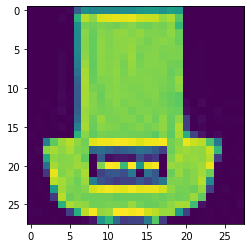

In [77]:
plt.imshow(Gen_Train_fm[0][0][1].reshape(28,28))

In [ ]:
history2 = model23.fit_generator(
    Gen_Train_fm,
    epochs=90,
    verbose=1,
     validation_data = Gen_Val_fm
)

Epoch 1/90
468/468 [==============================] - 8s 18ms/step - loss: 0.5945 - accuracy: 0.7823 - val_loss: 0.5461 - val_accuracy: 0.8018
Epoch 2/90
468/468 [==============================] - 8s 18ms/step - loss: 0.5789 - accuracy: 0.7872 - val_loss: 0.5488 - val_accuracy: 0.7967
Epoch 3/90
468/468 [==============================] - 8s 18ms/step - loss: 0.5679 - accuracy: 0.7923 - val_loss: 0.5258 - val_accuracy: 0.8103
Epoch 4/90
468/468 [==============================] - 9s 18ms/step - loss: 0.5595 - accuracy: 0.7951 - val_loss: 0.5396 - val_accuracy: 0.8016
Epoch 5/90
468/468 [==============================] - 8s 18ms/step - loss: 0.5455 - accuracy: 0.7999 - val_loss: 0.5228 - val_accuracy: 0.8060
Epoch 6/90
468/468 [==============================] - 8s 18ms/step - loss: 0.5402 - accuracy: 0.8031 - val_loss: 0.5076 - val_accuracy: 0.8163
Epoch 7/90
468/468 [==============================] - 9s 18ms/step - loss: 0.5335 - accuracy: 0.8029 - val_loss: 0.5014 - val_accuracy: 0.8220

In [68]:
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model23.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model23.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
#horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
#human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
#img_path = random.choice(horse_img_files + human_img_files)

img = cv2.imread('/home/beltain/Data/fmnist/img_0.jpg', cv2.IMREAD_GRAYSCALE)  # this is a PIL image
x = img.reshape(1,28,28,1) # Numpy array with shape (150, 150, 3)
x = x / 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model23.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) > 0 :
        print('nice')
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            #x = feature_map[0, :, :, i]
            x = feature_map[0, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

(1, 13, 13, 16)
nice


IndexError: index 13 is out of bounds for axis 1 with size 13